In this worksheet we will demonstrate learning sentiment extraction from text.

The dataset is the IDMB sentiment set where items were annotated by taggers as to if the text appeared to be expressing a positive or negative sentiment. This data set was produced by and used in:

> Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

The data can be found here: [https://ai.stanford.edu/~amaas/data/sentiment/](https://ai.stanford.edu/~amaas/data/sentiment/).

In our example we will use the GloVe embedding as our language model and Keras as our neural net software. The neural net architecture we are specifying is essentially a logistic regression over an average meaning of neighboring triplets of words in a document. The idea is: positive sentiment documents are often mostly positive utterances, and negative sentiment documents are often mostly negative utterances. We hope the non-sentiment carrying portions are largely ignored by the model.

In [1]:
# ensure plots print without needing to call show()
%matplotlib inline

In [2]:
# import our packages
import pandas
import numpy
import os
import gzip
import sys
import pickle
import textwrap

import wvpy.util

import sklearn.metrics
from sklearn.pipeline import make_pipeline

In [3]:
# set up Keras imports, this can be brittle
# no longer import keras, import tensorflow.keras
import tensorflow.keras as keras
# https://github.com/keras-team/keras/issues/12379#issuecomment-473823330
from tensorflow.keras import *
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
from tensorflow.keras.layers import *
#from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
#from keras.models import Model
#from keras.optimizers import RMSprop
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop
from tensorflow.keras.optimizers import *

In [4]:
# get our data and language model through data adaptors
sys.path.append('.')
# put data load on our path
sys.path.append('../data/IMDB')
from load_IMDB import load_IMDB
sys.path.append('../data/GloVe')
from document_encoder import GloveEncoder

In [5]:
# load the IMDB data
train_data, test_data = load_IMDB()

In [6]:
# show how many training examples
len(train_data.data)

25000

In [7]:
# show how many test examples
len(test_data.data)


25000

In [8]:
# load the glove vectors we need, uses about 4GB of memory
glove_path = '../data/GloVe/glove.840B.300d.zip'
k = 3  # how many neighboring words to model
encoder = GloveEncoder(
    glove_path=glove_path,
    k=k,
)

As a digression let's talk about the tokenization phase of our text processing solution.

In [9]:
# train the encoder on what words it is to recognize
encoder.fit(X=train_data.data)

# pull out tokenizer and code_book so we can look at them
tokenizer = encoder.tokenizer
code_book = encoder.code_book

The encoder maps strings into sequences of integer token ids.

In [10]:
txt = "I liked the story!"

toks = tokenizer.texts_to_sequences([txt])[0]

toks

[10, 421, 1, 62]

We can invert the map to recover the canonicalized words the token ids represent.

In [11]:
[tokenizer.index_word[t] for t in toks]

['i', 'liked', 'the', 'story']

With that in had, let's look at the procedure applied to our training data.

In [12]:
# a data item
train_example_id = 13
textwrap.wrap(
    train_data.data[train_example_id])

['Its not the cast. A finer group of actors, you could not find. Its not',
 'the setting. The director is in love with New York City, and by the',
 'end of the film, so are we all! Woody Allen could not improve upon',
 'what Bogdonovich has done here. If you are going to fall in love, or',
 'find love, Manhattan is the place to go. No, the problem with the',
 'movie is the script. There is none. The actors fall in love at first',
 "sight, words are unnecessary. In the director's own experience in",
 'Hollywood that is what happens when they go to work on the set. It is',
 'reality to him, and his peers, but it is a fantasy to most of us in',
 'the real world. So, in the end, the movie is hollow, and shallow, and',
 'message-less.']

In [13]:
# the sentiment, 1 is positive, 0 is negative
train_data.target[train_example_id]

0

In [14]:
example_toks = tokenizer.texts_to_sequences(
    [train_data.data[train_example_id]])

numpy.array(example_toks)

array([[  91,   21,    1,  174,    3,  601,    4,  153,   22,   97,   21,
         166,   91,   21,    1,  954,    1,  164,    6,    8,  116,   16,
         159,  779,  540,    2,   31,    1,  127,    4,    1,   19,   35,
          23,   72,   29, 2290, 1598,   97,   21, 4381,  722,   48,   45,
         221,  130,   44,   22,   23,  167,    5,  804,    8,  116,   39,
         166,  116, 3736,    6,    1,  270,    5,  137,   54,    1,  436,
          16,    1,   17,    6,    1,  226,   47,    6,  597,    1,  153,
         804,    8,  116,   30,   83, 1679,  712,   23, 1740,    8,    1,
        2024,  202,  581,    8,  359,   12,    6,   48,  567,   51,   33,
         137,    5,  154,   20,    1,  267,    9,    6,  632,    5,   87,
           2,   24, 8174,   18,    9,    6,    3,  936,    5,   88,    4,
         175,    8,    1,  144,  179,   35,    8,    1,  127,    1,   17,
           6, 4078,    2, 2007,    2,  746,  326]])

In [15]:
textwrap.wrap(
    tokenizer.sequences_to_texts(example_toks)[0])

['its not the cast a group of actors you could not find its not the',
 'setting the director is in love with new york city and by the end of',
 'the film so are we all woody allen could not improve upon what has',
 'done here if you are going to fall in love or find love manhattan is',
 'the place to go no the problem with the movie is the script there is',
 'none the actors fall in love at first sight words are unnecessary in',
 "the director's own experience in hollywood that is what happens when",
 'they go to work on the set it is reality to him and his peers but it',
 'is a fantasy to most of us in the real world so in the end the movie',
 'is hollow and shallow and message less']

A *very* important point is: we *must* save and share the tokenizer used during model construction. All of the model is in terms of the arbitrary token coding scheme built during training. We can *not* re-fit the tokenizer on new data, as that gives a different codebook that looks like gibberish with respect to the model. Also we need to transport code and data artifacts such as the GloVe embedding data, which we didn't produce, and the GloVe adaptor. Code can be stereotyped to a few re-usable pre-supplied themes (so one does not have to support arbitrary code execution), data is going to always be unique.

An example of what goes wrong when we think we can re-fit is shown below.

In [16]:
# fit a new tokenizer on a new data set (bad!)
tokenizer_2 = keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer_2.fit_on_texts(test_data.data)

In [17]:
# re-fit tokenizer assigns wrong symbols
mis_tokens = tokenizer_2.texts_to_sequences(
    [train_data.data[train_example_id]])

numpy.array(mis_tokens)

array([[  93,   22,    1,  179,    3,  496,    4,  151,   21,   98,   22,
         164,   93,   22,    1,  944,    1,  167,    6,    8,  110,   16,
         173,  988,  533,    2,   31,    1,  129,    4,    1,   19,   34,
          23,   73,   30, 4617, 2932,   98,   22, 4429,  645,   48,   45,
         217,  135,   40,   21,   23,  165,    5,  765,    8,  110,   38,
         164,  110, 4541,    6,    1,  281,    5,  139,   54,    1,  459,
          16,    1,   15,    6,    1,  230,   46,    6,  643,    1,  151,
         765,    8,  110,   29,   88, 1691,  640,   23, 1942,    8,    1,
        1720,  202,  534,    8,  375,   12,    6,   48,  537,   50,   33,
         139,    5,  159,   20,    1,  275,   10,    6,  603,    5,   85,
           2,   24, 7580,   18,   10,    6,    3, 1152,    5,   87,    4,
         180,    8,    1,  144,  183,   34,    8,    1,  129,    1,   15,
           6, 4767,    2, 2240,    2,  752,  361]])

In [18]:
# this is the text we would think we are processing
# if we re-fit the tokenizer
# notice it is word salad,
# we can't understand it and neither will our model
textwrap.wrap(
    tokenizer.sequences_to_texts(mis_tokens)[0]
)

['way you the world a side of old not any you director way you the mess',
 'the going is in life with lot masterpiece thinking and by the man of',
 'the film who are much at progresses alas any you nervous body what has',
 'almost why just not are look to team in life her director life ballet',
 'is the actor to something no the laugh with the for is the guy some is',
 'started the old team in life all most began somewhat are sing in the',
 'filmmaker own stories in stupid that is what obviously more they',
 'something to new on the money i is simple to because and his insert',
 'but i is a younger to him of things in the real seems who in the man',
 'the for is capital and portrays and sequel low']

Often the data scientist attempts to improve model quality by trying different algorithms or even just different data.

In this case we are trying the idea that smaller documents may have fewer irrelevant phrases to confuse the model. The hope is that such a model is better, and in fact better on all documents- not just small ones.

In our case the idea fails, all the texts work better than just the small ones. However, the data scientist usually tries *many* ideas and does come up with some subtle improvements.

In [19]:
# build a simple determination of big versus small texts
text_lens = [len(t) for t in train_data.data]
mid_text_len = numpy.median(text_lens)
is_big = numpy.array([len(t) > mid_text_len for t in train_data.data])


In [20]:
# build our neural net factory
# this one implements a logistic regression.

# get our data shape from using the encoder
# so we don't have the brittleness of hard-coding.
encode_dim = encoder.encode_text("this is an example text", k=k).shape[0]

def mk_model():
    """
    This is a simple logistic model.
    A more complicated neural net is often specified for text tasks.
    """
    logistic_model = Sequential()
    logistic_model.add(Input(shape=(encode_dim, )))
    logistic_model.add(Dense(1, activation='sigmoid'))
    logistic_model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['acc'])
    return logistic_model

logistic_model = mk_model()
logistic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 901       
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


2022-02-15 09:19:39.959226: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
# util fn to subset data
def select_from_list_like(items, selector):
    return [item for item, sel in zip(items, selector) if sel]


In [22]:
# training hyper-parameters
# often searching, on simulated out of sample data,
# for good values of these can impove model quality.
epochs=200
batch_size=512
validation_split=0.2

In [23]:
# shuffle rows of training data in case neural net batching takes in ordered chunks
permutation = numpy.random.choice(len(train_data.data), size=len(train_data.data), replace=False)
train_data_shuffled = [train_data.data[i] for i in permutation]
train_target_shuffled = [train_data.target[i] for i in permutation]


In [24]:
%%capture
# do the training on our first model, all the data
history_big = logistic_model.fit(
    encoder.transform(train_data_shuffled),
    numpy.asarray(train_target_shuffled),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split)

2022-02-15 09:20:15.296025: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [25]:
# wrap the text processing plus model
# as a single object implementing the model API
model = make_pipeline(encoder, logistic_model)

In [26]:
# get predictions on data not seen during training!
pred_test = model.predict(test_data.data)

There are a *lot* of evaluation metrics. With more time, we teach which few to use and how to read and use them effectively.

In [27]:
# get the confusion matrix, a great evaluation tool
eval_frame = pandas.DataFrame({
    'truth': numpy.array(test_data.target, dtype=float),
    'prediction': pred_test.reshape((pred_test.shape[0], )),
})

In [28]:
eval_frame

,truth,prediction
0,0.0,0.014966
1,0.0,0.114122
2,0.0,0.047213
3,0.0,0.212273
4,0.0,0.796412
...,...,...
24995,1.0,0.515508
24996,1.0,0.136242
24997,1.0,0.581570
24998,1.0,0.415901


In [29]:
eval_frame.dtypes

truth         float64
prediction    float32
dtype: object

Note, it can be fairly hard for the data scientist to control exact scalar types. So tools must tolerate interchanging floats and doubles.

<Figure size 432x288 with 0 Axes>

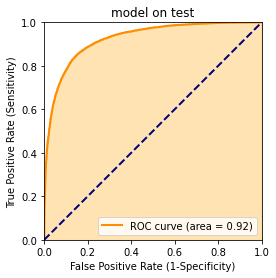

0.9242233280000001

In [30]:
# evaluate the results
wvpy.util.plot_roc(
    eval_frame['prediction'],
    eval_frame['truth'],
    title='model on test')


<Figure size 432x288 with 0 Axes>

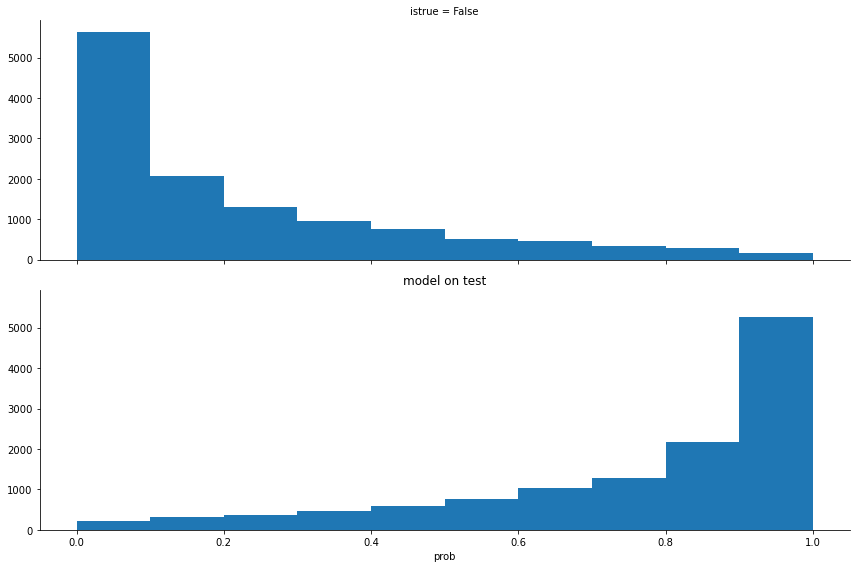

In [31]:
# evaluate the results
wvpy.util.dual_hist_plot(
    eval_frame['prediction'],
    eval_frame['truth'],
    truth_target=1,
    title='model on test')


In [32]:
confusion_matrix = pandas.crosstab(
    eval_frame['truth'] > 0.5,
    eval_frame['prediction'] > 0.5)

confusion_matrix


prediction,False,True
truth,,
False,10740,1760
True,1992,10508


In [33]:
# quantify the accuracy
# accuracy is often NOT the right metric to use!
# but it is the most common one you hear about.
# instead insist on 2 numbers:
#  precision and recall
#  or sensitivity and specificity
accuracy = (
        (confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,1]) /
        numpy.sum(numpy.sum(confusion_matrix))
)

accuracy

0.84992

We can try the model on our own text.

In [34]:
model.predict([
"""
To call The Princess Bride a classic is to understate it's significance. The Princess Bride is not only a great movie, it is above all else, a GOOD movie.
"""
])

array([[0.59190047]], dtype=float32)

We can save the whole process for later re-use.

In [35]:
# save model components
# Keras models are not pickleab until very recent versions
logistic_model.save("model_keras_step.keras")
with gzip.open('model_encoder_step.pkl.gz', 'wb') as of:
    pickle.dump(
        obj=encoder,
        file=of
    )


We repeat these steps for our alternating "train only on small documents" idea.

In [36]:
# make another model trained only on small texts
# perhaps these have fewer irrelevant words and make a
# better or different model
logistic_model_small = mk_model()

In [37]:
%%capture
history_small = logistic_model_small.fit(
    encoder.transform(select_from_list_like(train_data.data, is_big == False)),
    numpy.asarray(select_from_list_like(train_data.target, is_big == False)),
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation_split)

In [38]:
model_small = make_pipeline(encoder, logistic_model_small)

In [39]:
pred_test_small = model_small.predict(test_data.data)

In [40]:
eval_frame_small = pandas.DataFrame({
    'truth': numpy.array(test_data.target, dtype=float),
    'prediction': pred_test_small.reshape((pred_test_small.shape[0], )),
})

<Figure size 432x288 with 0 Axes>

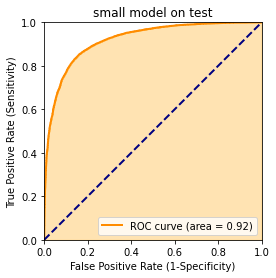

0.9200431008

In [41]:
wvpy.util.plot_roc(
    eval_frame_small['prediction'],
    eval_frame_small['truth'],
    title='small model on test')

Notice we have not improved things. Training on all the data was a bit better than training on a subset. However, if were wanting to apply this model to Tweets (instead of full reviews)- we would probably try this idea again.


And that is an example of natural language processing (NLP) learning to perform sentiment analysis using the Keras neural net package.

For more details one can dig into the included code in this diretory and the sibling data directories.

Copyright &copy; 2019-2022 Win-Vector LLC.  All rights reserved. [http://www.win-vector.com](http://www.win-vector.com)